# Import modules and set random seed

In [ ]:
import numpy as np
import scipy.sparse as sp
import torch
import pandas as pd
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt


seed = 0

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#Model Loading

In [ ]:
import logging

logging.basicConfig(level=logging.INFO)

In [ ]:
!git clone https://github.com/mwalmsley/zoobot.git

Cloning into 'zoobot'...
remote: Enumerating objects: 8206, done.
remote: Counting objects: 100% (2194/2194), done.
remote: Compressing objects: 100% (693/693), done.
remote: Total 8206 (delta 1520), reused 2157 (delta 1491), pack-reused 6012
Receiving objects: 100% (8206/8206), 334.15 MiB | 20.99 MiB/s, done.
Resolving deltas: 100% (5112/5112), done.


In [ ]:
!git pull

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
!pip install -e /content/zoobot[pytorch_colab]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/zoobot
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.4/952.4 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 kB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.7/276.7 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━

In [ ]:
# google colab needs this hack to make git-cloned packaged importable
# it's not needed locally
import os
import sys
zoobot_dir = '/content/zoobot'
os.chdir(zoobot_dir)
sys.path.append(zoobot_dir)
!git pull  # just to make sure we're up to date

Already up to date.


In [ ]:

# make a directory to place the checkpoint
# this could be anywhere, but Zoobot has this folder already
checkpoint_dir = os.path.join(zoobot_dir, 'data/pretrained_models/pytorch')  # Can place your checkpoint anywhere, 

# if not os.path.isdir(checkpoint_dir):
#   os.makedirs(checkpoint_dir)

In [ ]:

!wget --no-check-certificate 'https://dl.dropboxusercontent.com/s/kgkxkzsult1i8wc/gz_decals_dr5_greyscale_224px.ckpt?dl=0' -O $checkpoint_dir/checkpoint.ckpt


--2023-04-19 23:32:39--  https://dl.dropboxusercontent.com/s/kgkxkzsult1i8wc/gz_decals_dr5_greyscale_224px.ckpt?dl=0
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.65.15, 2620:100:601a:15::a27d:70f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.65.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16503601 (16M) [application/octet-stream]
Saving to: ‘/content/zoobot/data/pretrained_models/pytorch/checkpoint.ckpt’

/content/zoobot/dat 100%[===================>]  15.74M  14.3MB/s    in 1.1s    

2023-04-19 23:32:42 (14.3 MB/s) - ‘/content/zoobot/data/pretrained_models/pytorch/checkpoint.ckpt’ saved [16503601/16503601]



#Downloading GZ DECaLS GZD-5 dataset

In [ ]:
from galaxy_datasets import gz_decals_5 #using gz_decals for the dataset
data_dir = os.path.join(zoobot_dir, 'data/gz_decals_5')
train_catalog, label_cols = gz_decals_5(root=data_dir, download=True, train=True)

100%|██████████| 30757430/30757430 [00:01<00:00, 20365959.50it/s]


100%|██████████| 8195714/8195714 [00:00<00:00, 9932541.98it/s] 


100%|██████████| 11202332866/11202332866 [10:00<00:00, 18657410.82it/s]


Extracting /content/zoobot/data/gz_decals_5/decals_dr5_images.tar.gz to /content/zoobot/data/gz_decals_5


# Load model from checkpoint

In [ ]:
# TODO you can update these paths to suit own data
checkpoint_loc = os.path.join(zoobot_dir, 'data/pretrained_models/pytorch/checkpoint.ckpt')  # downloaded above
save_dir = os.path.join(zoobot_dir, 'results/pytorch/finetune/finetune_binary_classification')

In [ ]:
from zoobot.pytorch.estimators import define_model
model = define_model.ZoobotTree.load_from_checkpoint(checkpoint_loc)

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.0.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file data/pretrained_models/pytorch/checkpoint.ckpt`


#Make prediction on training dataset

In [ ]:
from zoobot.pytorch.predictions import predict_on_catalog
import pandas as pd
predict_on_catalog.predict(
  train_catalog,
  model,
  n_samples=1,
  label_cols=label_cols,
  save_loc=os.path.join(zoobot_dir, 'predictions.csv'),
  trainer_kwargs={'accelerator': 'gpu'},
  datamodule_kwargs={'num_workers': 2}
)
predictions = pd.read_csv(os.path.join(zoobot_dir, 'predictions.csv'))
predictions

GZDESI and GZRings not available from galaxy_datasets.pytorch.datasets - skipping


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

,id_str,smooth-or-featured-dr5_smooth_pred,smooth-or-featured-dr5_featured-or-disk_pred,smooth-or-featured-dr5_artifact_pred,disk-edge-on-dr5_yes_pred,disk-edge-on-dr5_no_pred,has-spiral-arms-dr5_yes_pred,has-spiral-arms-dr5_no_pred,bar-dr5_strong_pred,bar-dr5_weak_pred,...,spiral-arm-count-dr5_1_pred,spiral-arm-count-dr5_2_pred,spiral-arm-count-dr5_3_pred,spiral-arm-count-dr5_4_pred,spiral-arm-count-dr5_more-than-4_pred,spiral-arm-count-dr5_cant-tell_pred,merging-dr5_none_pred,merging-dr5_minor-disturbance_pred,merging-dr5_major-disturbance_pred,merging-dr5_merger_pred
0,J143752.90+292250.0,29.792881,26.129229,6.405056,12.684949,3.875178,1.425983,16.825745,1.519262,3.308208,...,3.855744,28.529251,3.554882,2.625924,3.212462,25.340429,16.753500,2.978610,1.071992,3.817652
1,J115319.63+274642.4,57.034351,16.264994,19.366203,2.901597,62.248249,1.348663,52.041473,1.724425,3.952025,...,8.741028,19.586220,4.997777,2.947560,5.145711,25.959238,11.630877,2.677904,1.077183,17.420578
2,J091304.01+132345.6,95.086441,11.520984,13.423775,6.041074,76.410065,1.552290,49.282516,1.260882,3.726640,...,6.078577,16.161230,6.857029,5.233385,6.750897,27.012945,49.260914,3.831494,1.080175,1.411280
3,J153401.15+241918.5,44.140366,24.108873,5.363680,3.459944,34.549454,2.148072,9.263426,7.336103,7.169558,...,4.512684,69.230263,1.811954,1.174277,1.074100,20.295811,61.625111,10.572494,1.935350,1.156299
4,J215331.36-082500.4,44.761192,16.492901,4.279356,4.368927,71.958572,1.824318,4.916069,2.306704,5.265335,...,4.576998,85.011200,1.152578,1.011991,1.031598,12.056261,77.133499,12.148683,2.008787,1.036836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182442,J150401.99+311434.2,33.911987,30.511452,3.373714,6.153496,79.133224,8.438389,4.045782,1.977335,8.701126,...,2.462334,19.483248,5.645348,1.781734,1.016395,17.302042,46.135654,12.416720,1.649228,1.376913
182443,J013534.12-014955.2,90.677849,12.796537,18.479614,7.864956,77.101509,1.471024,66.071991,1.169069,2.881692,...,6.864033,11.512002,9.084260,11.720748,14.866941,18.408112,46.736809,4.666990,1.581148,1.152033
182444,J145818.35+091959.9,90.586151,14.719015,5.088075,22.175615,21.992018,3.025922,23.894348,1.329834,3.915354,...,2.878377,74.104546,2.222490,3.013394,4.617952,44.275761,82.637390,6.829896,1.061375,1.142332
182445,J210708.21-074941.3,81.168808,11.141593,5.276741,15.352036,35.119942,4.060743,16.942251,1.350942,5.886767,...,3.576858,20.978493,3.214679,3.204926,2.055243,49.382969,59.723713,8.472310,1.219673,1.309056


# Merged prediction with original dataset

In [ ]:
train_catalog

,iauname,upload_group,active_learning_on,in_gzd_ab,png_loc,smooth-or-featured-dr5_total-votes,smooth-or-featured-dr5_smooth,smooth-or-featured-dr5_smooth_fraction,smooth-or-featured-dr5_featured-or-disk,smooth-or-featured-dr5_featured-or-disk_fraction,...,merging-dr12_neither_fraction,merging-dr12_tidal-debris_fraction,merging-dr12_both_fraction,merging-dr12_merger_fraction,dr_with_most_votes,relative_file_loc,file_loc,id_str,filename,subfolder
0,J143752.90+292250.0,active_priority,True,False,dr5/J143/J143752.90+292250.0.png,50,24.0,0.480000,22.0,0.440000,...,NaN,NaN,NaN,NaN,dr5,dr5/J143/J143752.90+292250.0.png,/content/zoobot/data/gz_decals_5/images/J143/J...,J143752.90+292250.0,J143752.90+292250.0.jpg,J143
1,J115319.63+274642.4,active_baseline,False,False,dr5/J115/J115319.63+274642.4.png,5,4.0,0.800000,0.0,0.000000,...,NaN,NaN,NaN,NaN,dr5,dr5/J115/J115319.63+274642.4.png,/content/zoobot/data/gz_decals_5/images/J115/J...,J115319.63+274642.4,J115319.63+274642.4.jpg,J115
2,J091304.01+132345.6,active_baseline,False,False,dr5/J091/J091304.01+132345.6.png,5,4.0,0.800000,0.0,0.000000,...,NaN,NaN,NaN,NaN,dr5,dr5/J091/J091304.01+132345.6.png,/content/zoobot/data/gz_decals_5/images/J091/J...,J091304.01+132345.6,J091304.01+132345.6.jpg,J091
3,J153401.15+241918.5,active_baseline,False,False,dr5/J153/J153401.15+241918.5.png,8,5.0,0.625000,2.0,0.250000,...,NaN,NaN,NaN,NaN,dr5,dr5/J153/J153401.15+241918.5.png,/content/zoobot/data/gz_decals_5/images/J153/J...,J153401.15+241918.5,J153401.15+241918.5.jpg,J153
4,J215331.36-082500.4,active_baseline,False,False,dr5/J215/J215331.36-082500.4.png,6,5.0,0.833333,1.0,0.166667,...,NaN,NaN,NaN,NaN,dr5,dr5/J215/J215331.36-082500.4.png,/content/zoobot/data/gz_decals_5/images/J215/J...,J215331.36-082500.4,J215331.36-082500.4.jpg,J215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182442,J150401.99+311434.2,active_baseline,False,False,dr5/J150/J150401.99+311434.2.png,5,3.0,0.600000,2.0,0.400000,...,NaN,NaN,NaN,NaN,dr5,dr5/J150/J150401.99+311434.2.png,/content/zoobot/data/gz_decals_5/images/J150/J...,J150401.99+311434.2,J150401.99+311434.2.jpg,J150
182443,J013534.12-014955.2,active_baseline,False,False,dr5/J013/J013534.12-014955.2.png,5,4.0,0.800000,0.0,0.000000,...,NaN,NaN,NaN,NaN,dr5,dr5/J013/J013534.12-014955.2.png,/content/zoobot/data/gz_decals_5/images/J013/J...,J013534.12-014955.2,J013534.12-014955.2.jpg,J013
182444,J145818.35+091959.9,active_baseline,False,False,dr5/J145/J145818.35+091959.9.png,8,6.0,0.750000,2.0,0.250000,...,NaN,NaN,NaN,NaN,dr5,dr5/J145/J145818.35+091959.9.png,/content/zoobot/data/gz_decals_5/images/J145/J...,J145818.35+091959.9,J145818.35+091959.9.jpg,J145
182445,J210708.21-074941.3,active_baseline,False,False,dr5/J210/J210708.21-074941.3.png,13,11.0,0.846154,1.0,0.076923,...,NaN,NaN,NaN,NaN,dr5,dr5/J210/J210708.21-074941.3.png,/content/zoobot/data/gz_decals_5/images/J210/J...,J210708.21-074941.3,J210708.21-074941.3.jpg,J210


In [ ]:
merged_df = pd.merge(train_catalog, predictions, on='id_str', how='inner')
merged_df.to_csv('merged.csv', index=False)

In [ ]:
merged_df

,iauname,upload_group,active_learning_on,in_gzd_ab,png_loc,smooth-or-featured-dr5_total-votes,smooth-or-featured-dr5_smooth,smooth-or-featured-dr5_smooth_fraction,smooth-or-featured-dr5_featured-or-disk,smooth-or-featured-dr5_featured-or-disk_fraction,...,spiral-arm-count-dr5_1_pred,spiral-arm-count-dr5_2_pred,spiral-arm-count-dr5_3_pred,spiral-arm-count-dr5_4_pred,spiral-arm-count-dr5_more-than-4_pred,spiral-arm-count-dr5_cant-tell_pred,merging-dr5_none_pred,merging-dr5_minor-disturbance_pred,merging-dr5_major-disturbance_pred,merging-dr5_merger_pred
0,J143752.90+292250.0,active_priority,True,False,dr5/J143/J143752.90+292250.0.png,50,24.0,0.480000,22.0,0.440000,...,3.855744,28.529251,3.554882,2.625924,3.212462,25.340429,16.753500,2.978610,1.071992,3.817652
1,J115319.63+274642.4,active_baseline,False,False,dr5/J115/J115319.63+274642.4.png,5,4.0,0.800000,0.0,0.000000,...,8.741028,19.586220,4.997777,2.947560,5.145711,25.959238,11.630877,2.677904,1.077183,17.420578
2,J091304.01+132345.6,active_baseline,False,False,dr5/J091/J091304.01+132345.6.png,5,4.0,0.800000,0.0,0.000000,...,6.078577,16.161230,6.857029,5.233385,6.750897,27.012945,49.260914,3.831494,1.080175,1.411280
3,J153401.15+241918.5,active_baseline,False,False,dr5/J153/J153401.15+241918.5.png,8,5.0,0.625000,2.0,0.250000,...,4.512684,69.230263,1.811954,1.174277,1.074100,20.295811,61.625111,10.572494,1.935350,1.156299
4,J215331.36-082500.4,active_baseline,False,False,dr5/J215/J215331.36-082500.4.png,6,5.0,0.833333,1.0,0.166667,...,4.576998,85.011200,1.152578,1.011991,1.031598,12.056261,77.133499,12.148683,2.008787,1.036836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182442,J150401.99+311434.2,active_baseline,False,False,dr5/J150/J150401.99+311434.2.png,5,3.0,0.600000,2.0,0.400000,...,2.462334,19.483248,5.645348,1.781734,1.016395,17.302042,46.135654,12.416720,1.649228,1.376913
182443,J013534.12-014955.2,active_baseline,False,False,dr5/J013/J013534.12-014955.2.png,5,4.0,0.800000,0.0,0.000000,...,6.864033,11.512002,9.084260,11.720748,14.866941,18.408112,46.736809,4.666990,1.581148,1.152033
182444,J145818.35+091959.9,active_baseline,False,False,dr5/J145/J145818.35+091959.9.png,8,6.0,0.750000,2.0,0.250000,...,2.878377,74.104546,2.222490,3.013394,4.617952,44.275761,82.637390,6.829896,1.061375,1.142332
182445,J210708.21-074941.3,active_baseline,False,False,dr5/J210/J210708.21-074941.3.png,13,11.0,0.846154,1.0,0.076923,...,3.576858,20.978493,3.214679,3.204926,2.055243,49.382969,59.723713,8.472310,1.219673,1.309056


# Converting Dirichlet Concentrations to Fractions

In [ ]:
for i in range(len(merged_df.columns)):
    print((i, merged_df.columns[i]))

(0, 'iauname')
(1, 'upload_group')
(2, 'active_learning_on')
(3, 'in_gzd_ab')
(4, 'png_loc')
(5, 'smooth-or-featured-dr5_total-votes')
(6, 'smooth-or-featured-dr5_smooth')
(7, 'smooth-or-featured-dr5_smooth_fraction')
(8, 'smooth-or-featured-dr5_featured-or-disk')
(9, 'smooth-or-featured-dr5_featured-or-disk_fraction')
(10, 'smooth-or-featured-dr5_artifact')
(11, 'smooth-or-featured-dr5_artifact_fraction')
(12, 'disk-edge-on-dr5_total-votes')
(13, 'disk-edge-on-dr5_yes')
(14, 'disk-edge-on-dr5_yes_fraction')
(15, 'disk-edge-on-dr5_no')
(16, 'disk-edge-on-dr5_no_fraction')
(17, 'has-spiral-arms-dr5_total-votes')
(18, 'has-spiral-arms-dr5_yes')
(19, 'has-spiral-arms-dr5_yes_fraction')
(20, 'has-spiral-arms-dr5_no')
(21, 'has-spiral-arms-dr5_no_fraction')
(22, 'bar-dr5_total-votes')
(23, 'bar-dr5_strong')
(24, 'bar-dr5_strong_fraction')
(25, 'bar-dr5_weak')
(26, 'bar-dr5_weak_fraction')
(27, 'bar-dr5_no')
(28, 'bar-dr5_no_fraction')
(29, 'bulge-size-dr5_total-votes')
(30, 'bulge-size-dr5_

In [ ]:
lsts = [[206, 207, 208], [209, 210], [211, 212], [213, 214, 215], 
        [216, 217, 218, 219, 220], [221, 222, 223], [224, 225, 226], 
        [227, 228, 229], [230, 231, 232, 233], [234, 235], [236, 237, 238, 239]]
for lst in lsts:
  for i in lst:
    sum = 0
    for j in lst:
      sum += merged_df[merged_df.columns[j]]
    merged_df[merged_df.columns[i] + '_frac'] = merged_df[merged_df.columns[i]] / sum
fraction_data = merged_df.filter(regex = 'frac|id_str')
fraction_data = fraction_data.fillna(0.)


# Histograms of Each Question

In [ ]:
label_cols =['smooth-or-featured-dr5_smooth',
 'smooth-or-featured-dr5_featured-or-disk',
 'smooth-or-featured-dr5_artifact',
 'disk-edge-on-dr5_yes',
 'disk-edge-on-dr5_no',
 'has-spiral-arms-dr5_yes',
 'has-spiral-arms-dr5_no',
 'bar-dr5_strong',
 'bar-dr5_weak',
 'bar-dr5_no',
 'bulge-size-dr5_dominant',
 'bulge-size-dr5_large',
 'bulge-size-dr5_moderate',
 'bulge-size-dr5_small',
 'bulge-size-dr5_none',
 'how-rounded-dr5_round',
 'how-rounded-dr5_in-between',
 'how-rounded-dr5_cigar-shaped',
 'edge-on-bulge-dr5_boxy',
 'edge-on-bulge-dr5_none',
 'edge-on-bulge-dr5_rounded',
 'spiral-winding-dr5_tight',
 'spiral-winding-dr5_medium',
 'spiral-winding-dr5_loose',
 'spiral-arm-count-dr5_1',
 'spiral-arm-count-dr5_2',
 'spiral-arm-count-dr5_3',
 'spiral-arm-count-dr5_4',
 'spiral-arm-count-dr5_more-than-4',
 'spiral-arm-count-dr5_cant-tell',
 'merging-dr5_none',
 'merging-dr5_minor-disturbance',
 'merging-dr5_major-disturbance',
 'merging-dr5_merger']

In [ ]:
def plot_histograms(label_cols, fraction_data):
    f_pred = fraction_data.filter(regex='pred|id_str')
    for i in label_cols:
        f_pred_i = np.array(f_pred.filter(regex=i))
        plt.figure()
        plt.hist(f_pred_i)
        plt.title(i+' Histogram')

<ipython-input-26-816992e2dcc6>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


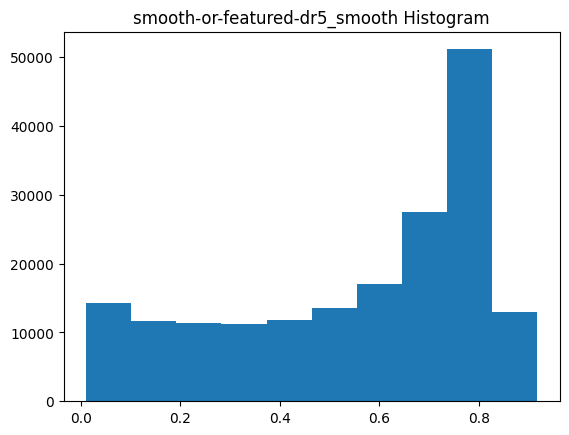

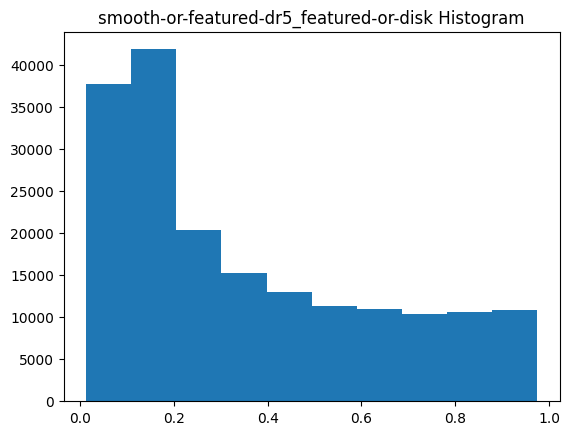

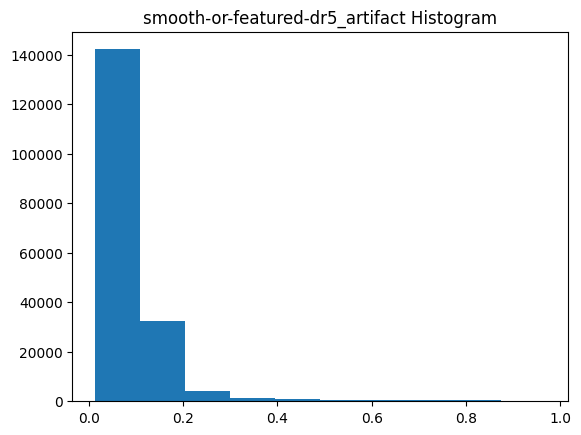

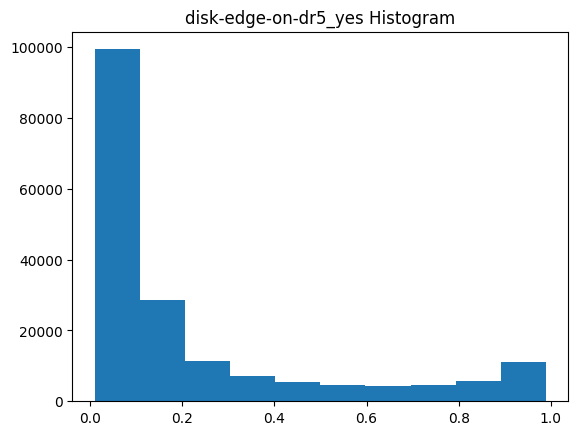

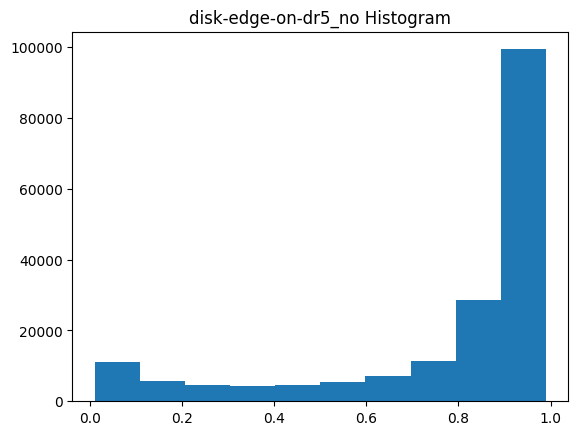

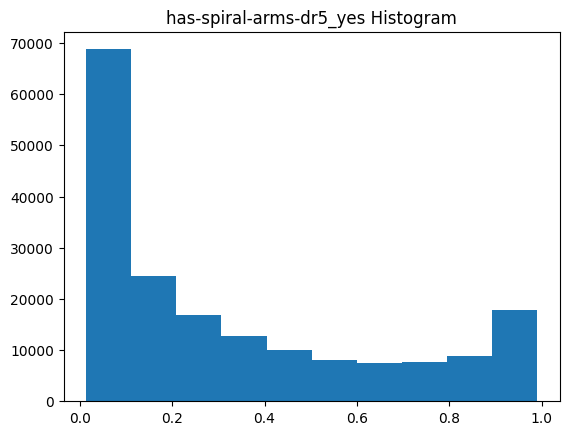

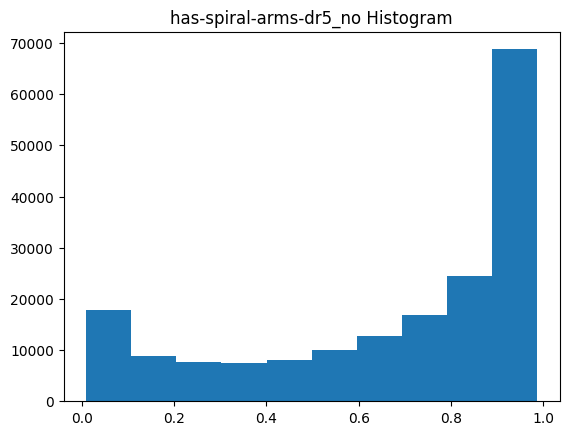

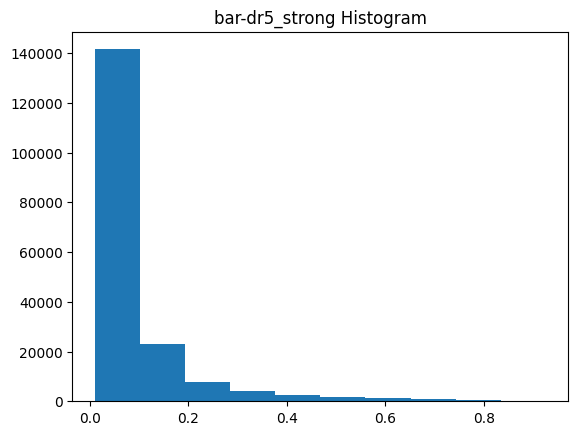

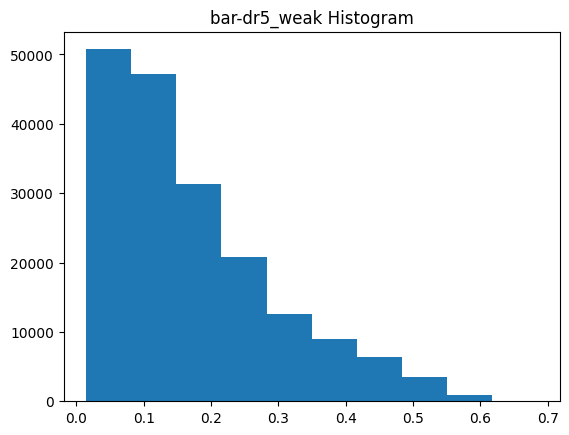

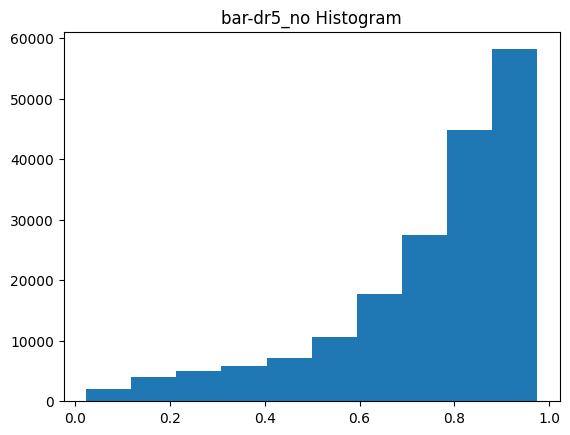

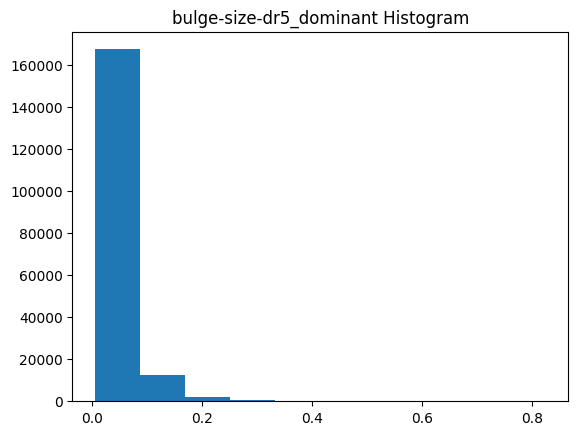

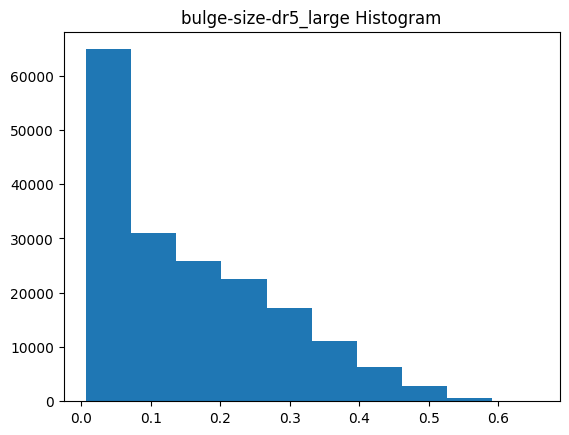

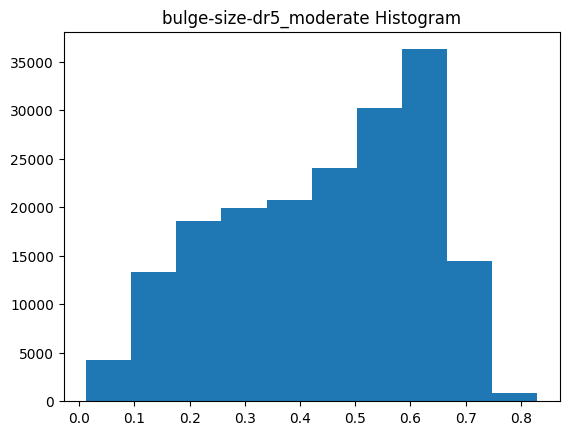

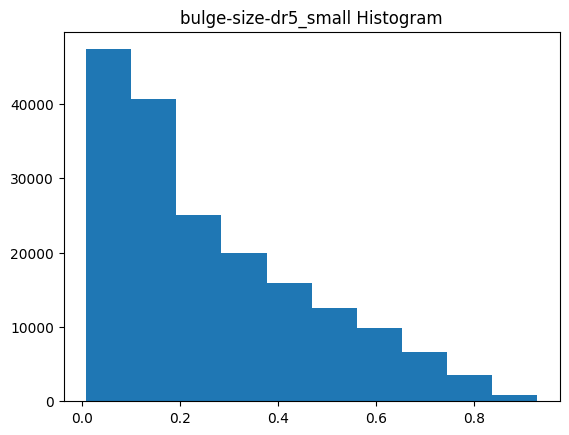

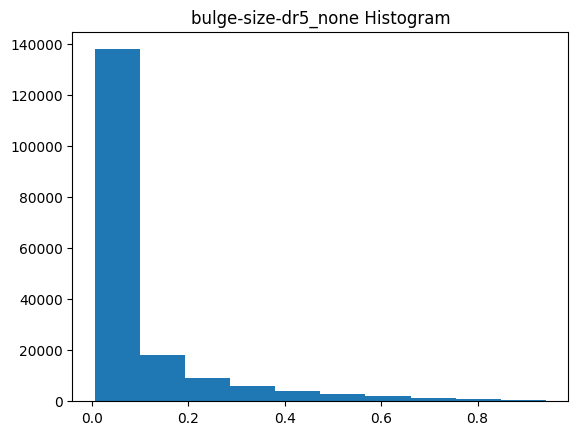

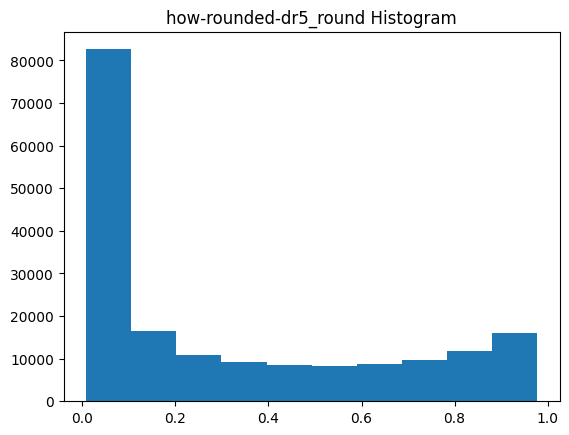

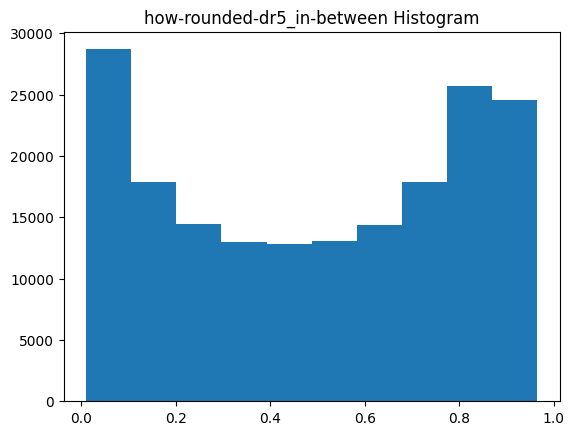

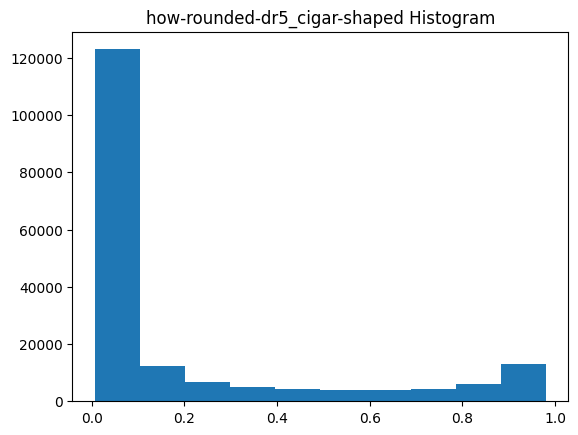

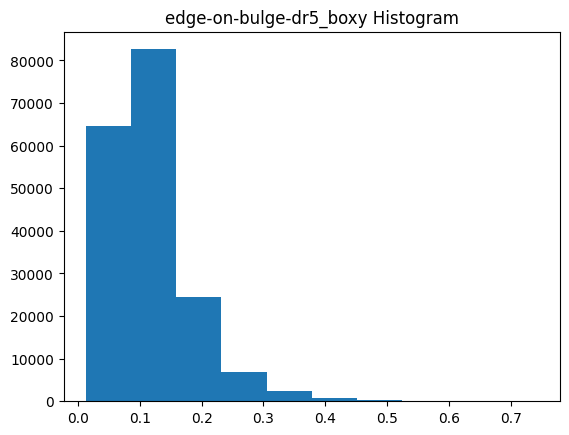

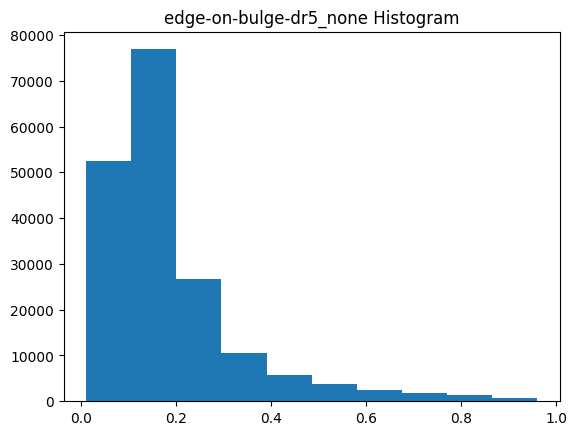

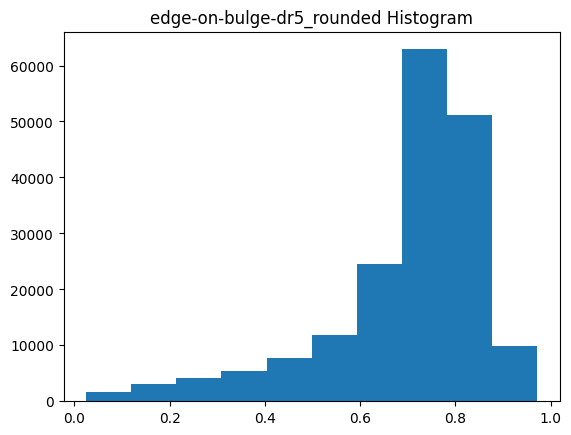

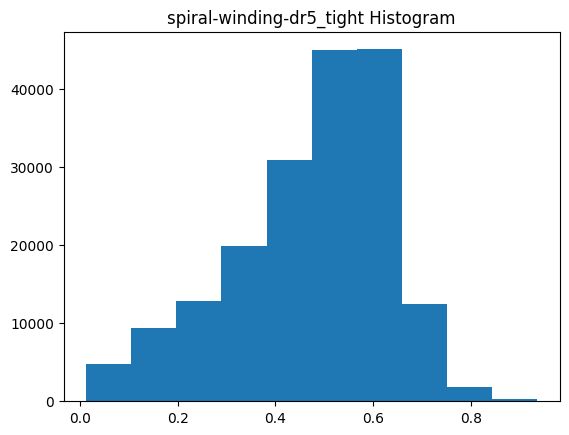

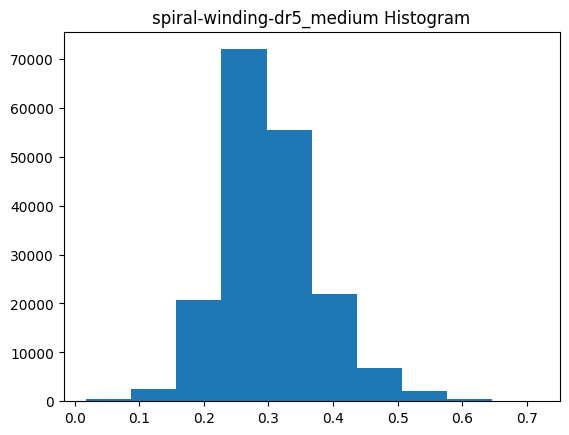

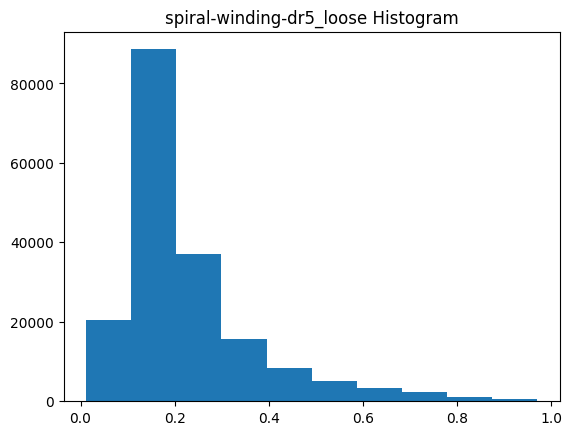

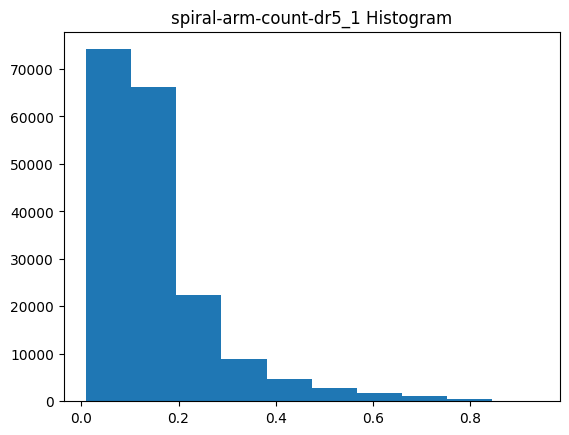

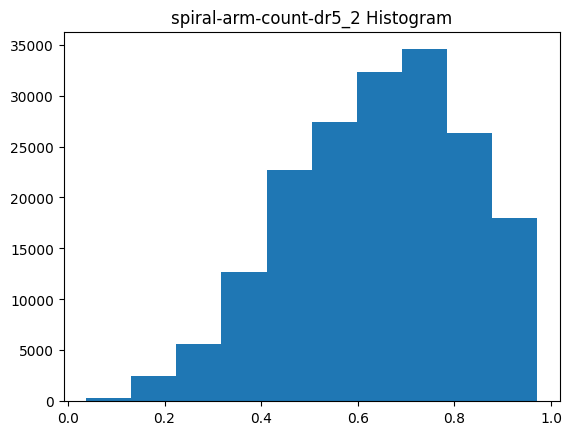

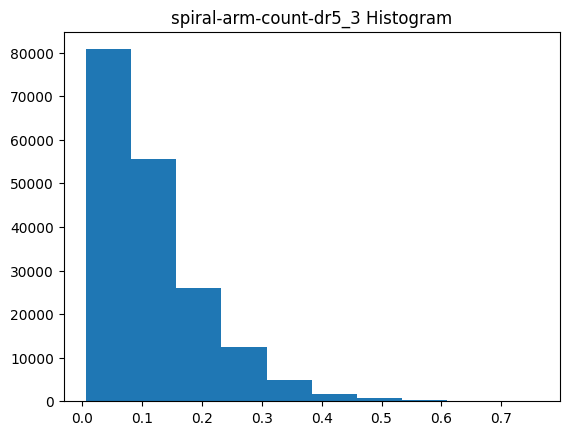

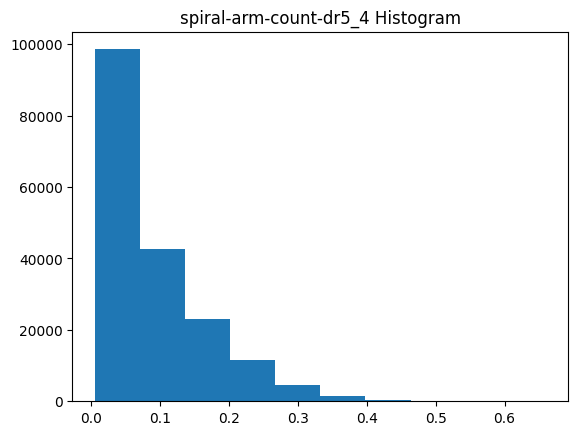

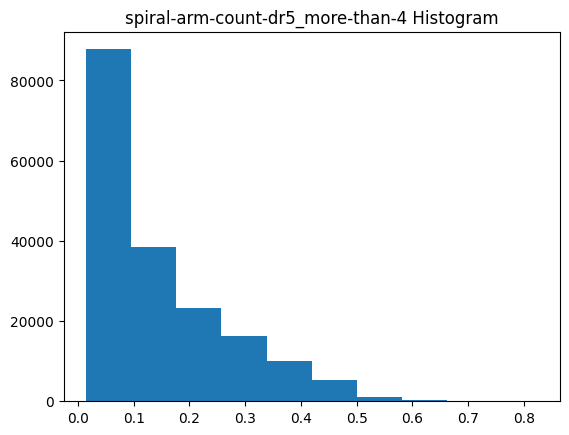

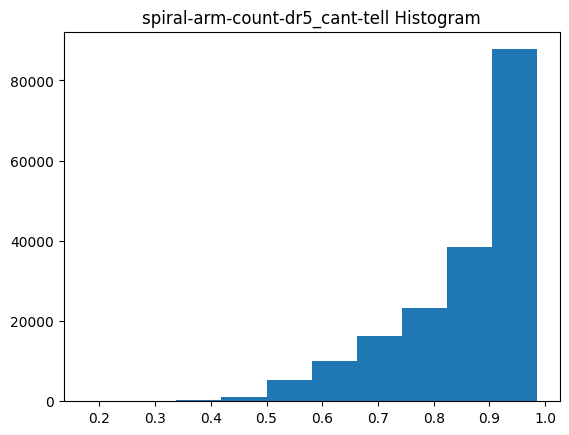

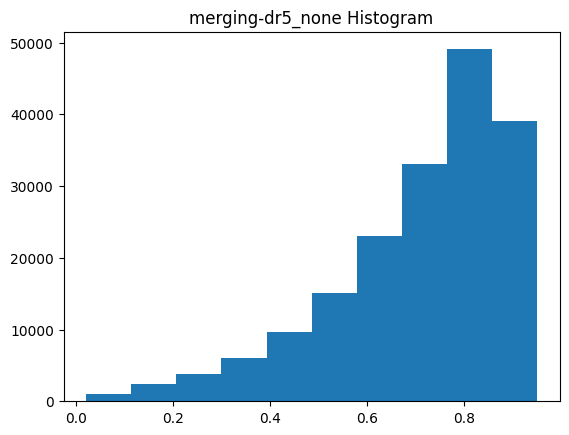

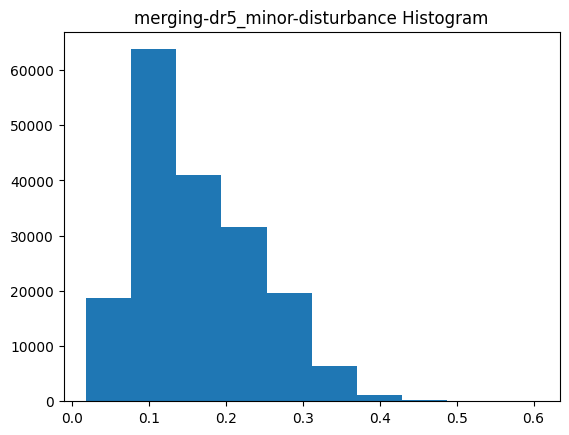

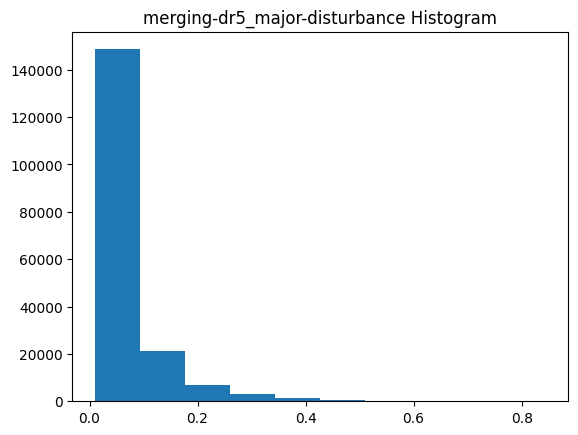

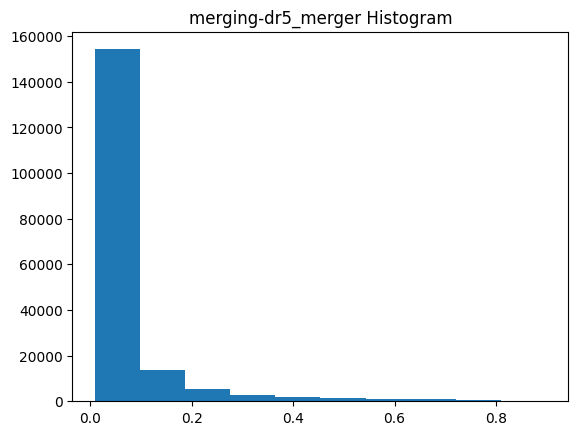

In [ ]:
plot_histograms(label_cols, fraction_data)

# Cross Entropy Loss Calculation

In [ ]:
fraction_data=fraction_data.fillna(0.)

In [ ]:
def cross_entropy(label_cols, fraction_data, question, question_weight, top_N):
    """Take a vector of pred_frac across all questions for a single galaxy,
    calculate the CE Loss for this galaxy against all others.
    For the specified question, assign a heavier weight to make CE Loss more 
    sensitive to this question.
    Sum the CE Loss over all questions
    """
    num_galaxies = fraction_data.shape[0]
    num_questions = len(label_cols)
    f_pred = fraction_data.filter(regex='pred|id_str')
    f_obs = fraction_data.filter(regex='fraction|id_str')
    # specific_question_s, specific_question_e = question_name_dict[question]

    # Initialize the CE Loss matrix
    ce_loss = np.zeros((num_galaxies, num_questions))
    # ce_loss_dict = np.zeros((num_galaxies, len(question_name_dict)))

    # Initialize maximum ce loss list
    max_ce_j = []
    max_ce_j_ques = []

    # Iterate over all galaxies
    for i in range(num_galaxies):
        # Get the predicted fractions for the i-th galaxy
        pred_frac = f_pred.iloc[i,1:]
        true_frac = f_obs.iloc[i,:-1]


        # Iterate over all questions
        for j in range(num_questions):
            # Get the true label for the i-th galaxy and j-th question
            true_frac_j = true_frac.iloc[j]

            # Get the predicted fraction for the i-th galaxy and j-th question
            pred_frac_j = pred_frac.iloc[j]

            # Compute the cross-entropy loss for the i-th galaxy and j-th question
            if pred_frac_j == 0:
               ce = 0
            else:
               ce = - true_frac_j * np.log(pred_frac_j) - (1 - true_frac_j) * np.log(1 - pred_frac_j)

            # Add a heavier weight to the specified question
            if j in question:
                ce *= question_weight
                # print(ce)

            # Add the CE Loss to the matrix
            ce_loss[i][j] = ce
            
        # Sum over all dictionary questions
        # for key, q in zip(question_name_dict, range(len(question_name_dict))):
        #     sum_range = list(question_name_dict[key])
        #     ce_loss_dict[i][q] = np.sum(ce_loss[i][sum_range[0]:sum_range[1]])


        #Find maximum for this row
        max_ce_j.append(max(ce_loss[i]))
        max_ques_id = np.where(ce_loss[i]==max_ce_j[i])[0].tolist()
        # print(max_ques_id)
        max_ce_j_ques.append(label_cols[max_ques_id[0]])


    
    #Find maximum for entire dataset
    # galaxy_w_max_ce = fraction_data.iloc[max_ce_j.index(max(max_ce_j)),:]
    # galaxy_w_max_ce_ques = max_ce_j_ques[max_ce_j.index(max(max_ce_j))]
    #top N max ce
    galaxy_indices = sorted(range(len(max_ce_j)), key=lambda i: max_ce_j[i], reverse=True)[:top_N]
    top_N_galaxies = fraction_data.iloc[galaxy_indices,:]
    top_N_ques = [max_ce_j_ques[i] for i in galaxy_indices]


    # Return the CE Loss matrix
    return ce_loss, top_N_galaxies, top_N_ques

In [ ]:
questions = [0,1,5,6,8,9,11,12,13,15,16,21,25,30]
question_weight = 5
ce_losses, top_N_galaxies,  top_N_ques = cross_entropy(label_cols, fraction_data, questions, question_weight, 10)

In [ ]:
top_N_ques

['how-rounded-dr5_round',
 'how-rounded-dr5_round',
 'how-rounded-dr5_round',
 'how-rounded-dr5_round',
 'bulge-size-dr5_large',
 'how-rounded-dr5_round',
 'how-rounded-dr5_round',
 'has-spiral-arms-dr5_yes',
 'bulge-size-dr5_large',
 'bulge-size-dr5_large']

In [ ]:
top_N_galaxies

,smooth-or-featured-dr5_smooth_fraction,smooth-or-featured-dr5_featured-or-disk_fraction,smooth-or-featured-dr5_artifact_fraction,disk-edge-on-dr5_yes_fraction,disk-edge-on-dr5_no_fraction,has-spiral-arms-dr5_yes_fraction,has-spiral-arms-dr5_no_fraction,bar-dr5_strong_fraction,bar-dr5_weak_fraction,bar-dr5_no_fraction,...,spiral-arm-count-dr5_1_pred_frac,spiral-arm-count-dr5_2_pred_frac,spiral-arm-count-dr5_3_pred_frac,spiral-arm-count-dr5_4_pred_frac,spiral-arm-count-dr5_more-than-4_pred_frac,spiral-arm-count-dr5_cant-tell_pred_frac,merging-dr5_none_pred_frac,merging-dr5_minor-disturbance_pred_frac,merging-dr5_major-disturbance_pred_frac,merging-dr5_merger_pred_frac
7988,0.200000,0.800000,0.000000,1.000000,0.000000,0.0,0.0,0.00,0.00,0.0,...,0.060542,0.785292,0.080695,0.073470,0.021648,0.978352,0.867380,0.101796,0.015266,0.015558
154115,0.200000,0.600000,0.200000,1.000000,0.000000,0.0,0.0,0.00,0.00,0.0,...,0.049873,0.837033,0.064820,0.048274,0.023605,0.976395,0.795019,0.137937,0.025800,0.041244
155752,0.125000,0.875000,0.000000,0.428571,0.571429,1.0,0.0,0.25,0.25,0.5,...,0.037587,0.926253,0.020859,0.015302,0.028328,0.971672,0.590210,0.287726,0.090839,0.031225
107695,0.200000,0.800000,0.000000,1.000000,0.000000,0.0,0.0,0.00,0.00,0.0,...,0.206055,0.647341,0.087259,0.059345,0.019857,0.980143,0.627986,0.250236,0.084388,0.037391
42013,0.000000,0.800000,0.200000,0.750000,0.250000,1.0,0.0,0.00,0.00,1.0,...,0.169266,0.296415,0.266284,0.268035,0.093282,0.906718,0.749388,0.188947,0.043415,0.018250
40389,0.142857,0.857143,0.000000,0.833333,0.166667,1.0,0.0,0.00,0.00,1.0,...,0.062364,0.783147,0.090752,0.063737,0.037943,0.962057,0.813699,0.124566,0.022441,0.039293
157825,0.500000,0.500000,0.000000,1.000000,0.000000,0.0,0.0,0.00,0.00,0.0,...,0.050737,0.711645,0.116262,0.121356,0.149632,0.850368,0.854773,0.106774,0.014975,0.023477
169884,0.333333,0.333333,0.333333,1.000000,0.000000,0.0,0.0,0.00,0.00,0.0,...,0.012867,0.967904,0.009632,0.009598,0.474888,0.525112,0.539115,0.208751,0.109913,0.142221
7913,0.600000,0.200000,0.200000,0.000000,1.000000,0.0,1.0,0.00,0.00,1.0,...,0.053117,0.866197,0.053610,0.027076,0.045691,0.954309,0.786447,0.159061,0.028815,0.025677
74087,0.800000,0.200000,0.000000,0.000000,1.000000,0.0,1.0,0.00,0.00,1.0,...,0.085773,0.811929,0.068136,0.034163,0.050176,0.949824,0.370718,0.346708,0.147185,0.135389


In [ ]:
col_name_ce = []
for i in label_cols:
    col_name_ce.append(i+'_CE_loss')

f_pred = fraction_data.filter(regex='pred|id_str')
ce_export = pd.DataFrame(ce_losses, columns = col_name_ce)
ce_export['id_str'] = f_pred.iloc[:,0]
ce_export
# ce_export.to_csv('merged_cross_entropy.csv', index=False)

,smooth-or-featured-dr5_smooth_CE_loss,smooth-or-featured-dr5_featured-or-disk_CE_loss,smooth-or-featured-dr5_artifact_CE_loss,disk-edge-on-dr5_yes_CE_loss,disk-edge-on-dr5_no_CE_loss,has-spiral-arms-dr5_yes_CE_loss,has-spiral-arms-dr5_no_CE_loss,bar-dr5_strong_CE_loss,bar-dr5_weak_CE_loss,bar-dr5_no_CE_loss,...,spiral-arm-count-dr5_2_CE_loss,spiral-arm-count-dr5_3_CE_loss,spiral-arm-count-dr5_4_CE_loss,spiral-arm-count-dr5_more-than-4_CE_loss,spiral-arm-count-dr5_cant-tell_CE_loss,merging-dr5_none_CE_loss,merging-dr5_minor-disturbance_CE_loss,merging-dr5_major-disturbance_CE_loss,merging-dr5_merger_CE_loss,id_str
0,3.461775,3.434061,0.281787,0.482186,0.482186,0.406748,0.406748,0.042784,0.478136,0.714036,...,6.730663,0.096706,0.070518,0.119357,2.184720,3.568096,0.301397,0.313175,0.610788,J143752.90+292250.0
1,2.897147,0.965034,0.500650,0.045560,3.111429,0.127925,18.392560,0.025235,0.294027,12.503411,...,3.882352,0.148249,0.084754,0.180839,1.799203,3.686850,0.085152,0.033386,0.695074,J115319.63+274642.4
2,2.502949,0.504537,0.533024,0.076091,2.613624,0.155059,17.444251,0.022444,0.339232,12.164045,...,3.181548,0.222815,0.165397,0.223074,1.609715,3.169991,0.722227,0.019625,0.025718,J091304.01+132345.6
3,3.314570,2.883174,0.393594,0.095442,0.095442,4.696495,4.696495,0.705281,3.542620,0.898231,...,0.514220,0.023898,0.015422,0.051569,2.990500,1.001340,0.151317,0.026042,0.015477,J153401.15+241918.5
4,2.545865,2.357664,0.067530,0.058943,0.058943,1.578041,1.578041,0.146797,1.867270,2.972646,...,13.054026,0.012641,0.011091,0.082101,2.540576,0.899038,0.141082,0.021997,0.011293,J215331.36-082500.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182442,3.465341,3.390567,0.051043,0.074886,0.074886,1.958351,1.958351,0.063720,1.584873,2.027702,...,5.442997,0.213437,0.062577,0.057084,1.474365,1.443635,0.225196,0.027148,0.022614,J150401.99+311434.2
182443,2.546111,0.554262,0.508851,0.097134,2.379840,0.110099,19.134029,0.017010,0.212320,14.198635,...,1.739394,0.263775,0.355452,0.592017,0.805668,0.734927,0.090151,0.029641,0.021510,J013534.12-014955.2
182444,2.889065,3.055261,0.047186,0.688999,0.688999,0.596188,10.928319,0.022655,0.341134,12.132153,...,11.578805,0.027403,0.037339,0.099211,2.359697,3.285607,0.392360,0.567520,0.012540,J145818.35+091959.9
182445,2.150406,1.394166,0.275731,0.362649,0.362649,1.074272,1.074272,0.034599,0.801949,1.005661,...,5.654738,0.109573,0.109222,0.040776,3.219987,2.960007,0.626196,0.017396,0.018683,J210708.21-074941.3


# Similarity score calculation

In [ ]:
useful_lst = []
for col in merged_df.columns:
  if "frac" in col and "dr5" in col:
    useful_lst.append(col)
useful_lst.append("id_str")
merged_useful = merged_df[useful_lst]
merged_useful = merged_useful.fillna(0.)
merged_useful

,smooth-or-featured-dr5_smooth_fraction,smooth-or-featured-dr5_featured-or-disk_fraction,smooth-or-featured-dr5_artifact_fraction,disk-edge-on-dr5_yes_fraction,disk-edge-on-dr5_no_fraction,has-spiral-arms-dr5_yes_fraction,has-spiral-arms-dr5_no_fraction,bar-dr5_strong_fraction,bar-dr5_weak_fraction,bar-dr5_no_fraction,...,spiral-arm-count-dr5_2_pred_frac,spiral-arm-count-dr5_3_pred_frac,spiral-arm-count-dr5_4_pred_frac,spiral-arm-count-dr5_more-than-4_pred_frac,spiral-arm-count-dr5_cant-tell_pred_frac,merging-dr5_none_pred_frac,merging-dr5_minor-disturbance_pred_frac,merging-dr5_major-disturbance_pred_frac,merging-dr5_merger_pred_frac,id_str
0,0.480000,0.440000,0.080000,0.818182,0.181818,0.0,1.0,0.00,0.0,1.00,...,0.739755,0.092177,0.068089,0.112509,0.887491,0.680435,0.120975,0.043538,0.155052,J143752.90+292250.0
1,0.800000,0.000000,0.200000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.00,...,0.539973,0.137784,0.081261,0.165431,0.834569,0.354529,0.081627,0.032834,0.531009,J115319.63+274642.4
2,0.800000,0.000000,0.200000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.00,...,0.470758,0.199737,0.152443,0.199945,0.800055,0.886245,0.068932,0.019433,0.025390,J091304.01+132345.6
3,0.625000,0.250000,0.125000,0.000000,1.000000,0.5,0.5,0.50,0.5,0.00,...,0.902268,0.023615,0.015304,0.050262,0.949738,0.818511,0.140425,0.025706,0.015358,J153401.15+241918.5
4,0.833333,0.166667,0.000000,0.000000,1.000000,0.0,1.0,0.00,0.0,1.00,...,0.926525,0.012562,0.011030,0.078821,0.921179,0.835431,0.131582,0.021757,0.011230,J215331.36-082500.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182442,0.600000,0.400000,0.000000,0.000000,1.000000,1.0,0.0,0.00,0.0,1.00,...,0.663312,0.192197,0.060660,0.055485,0.944515,0.749217,0.201640,0.026783,0.022360,J150401.99+311434.2
182443,0.800000,0.000000,0.200000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.00,...,0.293816,0.231853,0.299143,0.446789,0.553211,0.863307,0.086207,0.029206,0.021280,J013534.12-014955.2
182444,0.750000,0.250000,0.000000,1.000000,0.000000,0.0,0.0,0.00,0.0,0.00,...,0.901309,0.027031,0.036651,0.094449,0.905551,0.901456,0.074504,0.011578,0.012461,J145818.35+091959.9
182445,0.846154,0.076923,0.076923,0.000000,1.000000,0.0,1.0,0.00,0.0,1.00,...,0.677273,0.103783,0.103468,0.039956,0.960044,0.844453,0.119793,0.017245,0.018509,J210708.21-074941.3


In [ ]:
def get_top_k_most_similar_CE(weight, specific_question, given_index, is_pred, df, k):
  """
  specific_question: it has to be one of the keys of question_name_dict. 
  """

  specific_question_i = df.columns.get_loc(specific_question + "_fraction")

  given_img_arr = df.iloc[given_index].values.squeeze()
  all_img_arr = df.values

  if is_pred:
    specific_question_i += 34
    ce_error = (-1) * np.sum(given_img_arr[34:specific_question_i] * np.log(all_img_arr[:, 34:specific_question_i].astype(float)+ 1e-10) + (1 - given_img_arr[34:specific_question_i]) * np.log(1 - all_img_arr[:, 34:specific_question_i].astype(float)+ 1e-10), axis=1)
    ce_error += (-1) * weight * np.sum(given_img_arr[specific_question_i - 34: specific_question_i + 1 -34] * np.log(all_img_arr[:, specific_question_i: specific_question_i + 1].astype(float) + 1e-10) + (1 - given_img_arr[specific_question_i -34: specific_question_i + 1 -34]) * np.log(1 - all_img_arr[:, specific_question_i: specific_question_i + 1].astype(float) + 1e-10), axis=1)
    ce_error += (-1) * np.sum(given_img_arr[specific_question_i + 1:68] * np.log(all_img_arr[:, specific_question_i + 1:68].astype(float)+ 1e-10) + (1 - given_img_arr[specific_question_i + 1:68]) * np.log(1 - all_img_arr[:, specific_question_i + 1:68].astype(float) + 1e-10), axis=1)
  else:
    # actual
    ce_error = (-1) * np.sum(given_img_arr[:specific_question_i] * np.log(all_img_arr[:, :specific_question_i].astype(float) + 1e-10) + (1 - given_img_arr[:specific_question_i]) * np.log(1 - all_img_arr[:, :specific_question_i].astype(float) + 1e-10), axis=1)
    ce_error += (-1) * weight * np.sum(given_img_arr[specific_question_i + 34: specific_question_i + 1 + 34] * np.log(all_img_arr[:, specific_question_i: specific_question_i + 1].astype(float)+ 1e-10) + (1 - given_img_arr[specific_question_i + 34: specific_question_i + 1 + 34]) * np.log(1 - all_img_arr[:, specific_question_i: specific_question_i + 1].astype(float) + 1e-10), axis=1)
    ce_error += (-1) * np.sum(given_img_arr[specific_question_i + 1:34] * np.log(all_img_arr[:, specific_question_i + 1:34].astype(float) + 1e-10) + (1 - given_img_arr[specific_question_i + 1:34]) * np.log(1 - all_img_arr[:, specific_question_i + 1:34].astype(float) + 1e-10), axis=1)

  sorted_indices = np.argsort(ce_error)
  top_k_indices = sorted_indices[0: k]
  
  return all_img_arr[top_k_indices, 68]

In [ ]:
original_lst = [7988, 154115, 155752, 107695, 42013, 40389, 157825, 169884, 7913, 74087]
question = ['how-rounded-dr5_round', 'how-rounded-dr5_round', 'how-rounded-dr5_round', 
            'how-rounded-dr5_round', 'bulge-size-dr5_large', 'how-rounded-dr5_round', 
            'how-rounded-dr5_round', 'has-spiral-arms-dr5_yes', 'bulge-size-dr5_large', 
            'bulge-size-dr5_large']
pred_lst = []
actual_lst = []
for i in range(len(original_lst)):
  pred_lst.append(get_top_k_most_similar_CE(5, question[i], original_lst[i], True, merged_useful, 1)[0])
  actual_lst.append(get_top_k_most_similar_CE(5, question[i], original_lst[i], False, merged_useful, 1)[0])

In [ ]:
pred_lst

['J153503.65+222540.6',
 'J153503.65+222540.6',
 'J101305.12-023807.9',
 'J153503.65+222540.6',
 'J133904.88+244034.3',
 'J101305.12-023807.9',
 'J143957.79+030755.4',
 'J092443.11+003335.5',
 'J155037.01+300522.6',
 'J111722.39-025613.0']

In [ ]:
actual_lst

['J111606.95+122707.8',
 'J140214.53+055535.8',
 'J143925.22+065605.1',
 'J010521.60-010724.3',
 'J152222.74-012805.1',
 'J115040.95+045457.2',
 'J001033.53+142426.4',
 'J154037.02-015702.3',
 'J105842.03+063641.7',
 'J133704.99-012510.0']

# Prediction based on the images we are interested in


In [ ]:
train_catalog['id_str'] = train_catalog['id_str'].astype("string")

In [ ]:
#order CE loss = [original, predict, actual]
one = ['J113514.30-060216.9','J153503.65+222540.6','J111606.95+122707.8']
# two = ['J143303.43+075340.8','J112644.39+302846.7','J103402.06+054415.0']
# three = ['J145304.86+081749.4','J102828.94+011459.5','J120847.24-010217.1']
# four = ['J131026.04+245522.8','J022128.79-042447.0', 'J134202.89+004347.0']
# five = ['J002257.29+161512.0','J115425.04-021910.3', 'J151057.88-023953.1']
# six = ['J075951.86+172534.9','J152753.67+050836.9', 'J003922.98+024752.3']
# seven = ['J084121.88+151958.9','J111005.56+110358.6', 'J084121.88+151958.9']
# eight = ['J102443.02+105523.1','J230553.99+171813.9', 'J113005.71+064753.3']
# nine = ['J101551.42+244340.9','J023436.22-010828.7', 'J104320.24+141931.3']
# ten = ['J141801.27+273338.3','J145124.41+180130.4','J113755.68+203326.6']
question = ['how-rounded-dr5_round', 
            'how-rounded-dr5_round', 
            'how-rounded-dr5_round', 
            'how-rounded-dr5_round', 
            'bulge-size-dr5_large', 
            'how-rounded-dr5_round', 
            'how-rounded-dr5_round', 
            'has-spiral-arms-dr5_yes', 
            'bulge-size-dr5_large', 
            'bulge-size-dr5_large']
result = train_catalog.loc[train_catalog['id_str'].isin(one)]

In [ ]:
from zoobot.pytorch.predictions import predict_on_catalog
import pandas as pd
torch.manual_seed(42)
np.random.seed(42)
predict_on_catalog.predict(
  result,
  model,
  n_samples=1,
  label_cols=label_cols,
  save_loc=os.path.join(zoobot_dir, 'predictions_three.csv'),
  trainer_kwargs={'accelerator': 'gpu'},
  datamodule_kwargs={'num_workers': 2}
)
predictions_three = pd.read_csv(os.path.join(zoobot_dir, 'predictions_three.csv'))
predictions_three

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

,id_str,smooth-or-featured-dr5_smooth_pred,smooth-or-featured-dr5_featured-or-disk_pred,smooth-or-featured-dr5_artifact_pred,disk-edge-on-dr5_yes_pred,disk-edge-on-dr5_no_pred,has-spiral-arms-dr5_yes_pred,has-spiral-arms-dr5_no_pred,bar-dr5_strong_pred,bar-dr5_weak_pred,...,spiral-arm-count-dr5_1_pred,spiral-arm-count-dr5_2_pred,spiral-arm-count-dr5_3_pred,spiral-arm-count-dr5_4_pred,spiral-arm-count-dr5_more-than-4_pred,spiral-arm-count-dr5_cant-tell_pred,merging-dr5_none_pred,merging-dr5_minor-disturbance_pred,merging-dr5_major-disturbance_pred,merging-dr5_merger_pred
0,J153503.65+222540.6,13.337926,8.242126,7.893057,4.775272,5.302061,1.449290,7.742511,1.411979,2.653953,...,7.260067,9.369393,1.986662,1.144983,1.408514,17.312614,9.586940,1.676747,1.049947,4.855091
1,J113514.30-060216.9,56.643715,29.594038,3.356779,41.733818,4.376857,7.022766,6.675148,3.592313,3.057576,...,2.346950,29.143362,3.036731,2.674475,1.297853,55.108273,73.143478,9.043283,1.195736,1.175503
2,J111606.95+122707.8,35.982224,35.287914,2.922147,15.920939,2.964839,6.104595,5.009940,3.285577,5.261366,...,4.847972,51.406487,2.418332,1.243521,1.107833,32.703075,20.613106,10.504207,2.500789,1.294005


In [ ]:
location = predictions_three.columns.get_loc(question[1] + "_pred")-1

#Saliancy Map Model Load


In [ ]:
!git clone https://github.com/jacobgil/pytorch-grad-cam.git

Cloning into 'pytorch-grad-cam'...
remote: Enumerating objects: 1097, done.
remote: Total 1097 (delta 0), reused 0 (delta 0), pack-reused 1097
Receiving objects: 100% (1097/1097), 110.16 MiB | 27.36 MiB/s, done.
Resolving deltas: 100% (609/609), done.


At this step, change pytorch-grad-cam folder to pytorchgradcam first since - is not readable

In [ ]:
cd /content/zoobot

/content


In [ ]:
# Define the paths to the old and new folder names
old_folder_name = "pytorch-grad-cam"
new_folder_name = "pytorchgradcam"

# Rename the folder
os.rename(old_folder_name, new_folder_name)

In [ ]:
cd /content/zoobot/pytorchgradcam

/content/zoobot/pytorchgradcam


In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Saliancy Map Running

Get image as image tensor

In [ ]:
from galaxy_datasets.pytorch.galaxy_datamodule import GalaxyDataModule
torch.manual_seed(42)
np.random.seed(42)
predict_datamodule = GalaxyDataModule(
        label_cols=None,  # not using label_cols to load labels, we're only using it to name our predictions
        predict_catalog=result
)

# Get the first image in the dataset
predict_datamodule.setup(stage='predict')  
input_tensor = next(iter(predict_datamodule.predict_dataloader()))

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
image_tensor = input_tensor[2]
first_image = image_tensor.unsqueeze(0).cuda()
gray_img = np.array(image_tensor.unsqueeze(-1).cpu(), dtype=np.float32) / 255.0

In [ ]:
import cv2
import numpy as np
def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      use_rgb: bool = False,
                      colormap: int = cv2.COLORMAP_JET,
                      image_weight: float = 0.5) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default the heatmap is in BGR format.
    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :param image_weight: The final result is image_weight * img + (1-image_weight) * mask.
    :returns: The default image with the cam overlay.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")

    if image_weight < 0 or image_weight > 1:
        raise Exception(
            f"image_weight should be in the range [0, 1].\
                Got: {image_weight}")

    cam = (1 - image_weight) * heatmap + image_weight * img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [ ]:
class MultiLabelBinaryOutputTarget:
    def __init__(self, output_index, category):
        self.category = category
        self.output_index = output_index

    def __call__(self, model_output):
        if self.category == 1:
            sign = 1
        else:
            sign = -1
        print(model_output)
        return model_output[self.output_index] * sign

In [ ]:
from pytorchgradcam.pytorch_grad_cam import GradCAM,HiResCAM
torch.manual_seed(42)
np.random.seed(42)
model = model.to("cuda")
target_layer = [model.encoder.blocks[5][0]]
# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = HiResCAM(model=model, target_layers=target_layer)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets=[MultiLabelBinaryOutputTarget(output_index=1, category=location)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=first_image, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]

visualisation = show_cam_on_image(gray_img, grayscale_cam)

tensor([33.6453, 37.3223,  2.3064, 21.7578,  2.0685,  6.0048,  4.0510,  2.7179,
         3.7281, 12.7523,  1.1175,  2.1269, 14.2552, 27.9919,  9.3204,  1.0096,
         2.3104, 91.5261,  1.9099, 12.5824,  4.7770,  4.2652,  5.8348,  5.5424,
         6.8096, 54.6035,  2.0950,  1.1776,  1.0775, 31.1638, 17.2823,  8.3796,
         1.6373,  1.2513], device='cuda:0', grad_fn=<UnbindBackward0>)


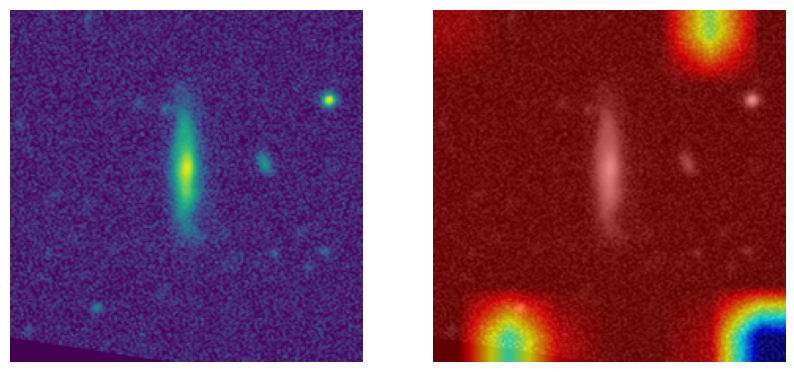

In [ ]:
import matplotlib.pyplot as plt
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# Show the images on each subplot
ax1.imshow(gray_img[0])
ax1.axis('off')
ax2.imshow(visualisation[0])
ax2.axis('off')

# Display the figure
plt.show()